# What secretion rate should we use in Jonklaas patients?

In [28]:
using Revise
using DifferentialEquations
using Thyrosim
using DiffEqCallbacks
using DiffEqParamEstim
using Plots
using Optim
using Statistics
using LinearAlgebra
using CSV
using StatsPlots

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278


In [2]:
BLAS.set_num_threads(1)
Threads.nthreads()

8

# Import Jonklaas data

$$ \textbf{1st visit} \rightarrow \text{1 week} \rightarrow \textbf{2nd visit} \rightarrow \text{1 day} \rightarrow \textbf{SURGERY} \rightarrow \text{8 weeks} \rightarrow \textbf{3rd visit} \rightarrow \text{8 weeks} \rightarrow \textbf{4th visit}$$

+ 4 measurements of FT4, T3 and TSH for 50 patients. 
+ patients were never diagnosed with hyper/hypo-thyroidism
+ their first 2 TSH measurements were normal

In [3]:
# jonklaas data
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data_new()

([61.8 62.8 1.72 1.0; 64.1 67.1 1.6 0.0; … ; 78.1 77.2 1.79 1.0; 89.7 89.7 1.78 0.0], [100.0 112.0; 112.0 125.0; … ; 137.0 137.0; 137.0 137.0], [1.19 1.24 1.45 1.31; 1.14 0.98 1.64 1.61; … ; 1.06 0.95 1.2 1.11; 1.0 1.1 1.3 1.4], [1.71 1.71 1.44 1.14; 1.08 1.19 1.48 1.39; … ; 0.96 1.02 0.86 1.07; 1.0 1.09 1.01 1.1], [0.63 0.7 0.37 0.9; 1.4 1.6 0.82 0.45; … ; 1.6 1.25 2.9 3.6; 0.84 0.85 0.8 0.7])

In [4]:
function plot_sim_data(sol, T4end, T3end, TSHend)
    title = "Thyrosim simulation"
    
    # parameters to adjust figure limits
    p = sol.prob.p 
    t4lim, t3lim, tshlim = 140, 4, 10
    T4 = 777.0 * sol[1, :] / p[47]
    T3 = 651.0 * sol[4, :] / p[47]
    TSH = 5.6 * sol[7, :] / p[48]
    
    # set margins
    t4lim = max(1.2maximum(T4), 110.0)
    t3lim = max(1.2maximum(T3), 2.5)
    tshlim = max(1.2maximum(TSH), 5.5)
    
    # make T4/T3/TSH plots
    p1 = plot(sol.t / 24.0, T4, ylim=(0, t4lim), label="",
    ylabel="T4 (mcg/L)", title=title)
    p1 = hline!([45, 120], label= "")
    
    p2 = plot(sol.t / 24.0, T3, ylim=(0, t3lim), legend=false, 
       ylabel="T3 (mcg/L)")
    p2 = hline!([0.6, 1.8], legend=false)
    
    p3 = plot(sol.t / 24.0, TSH, ylim=(0, tshlim), legend=false,
       ylabel="TSH (mU/L)", xlabel="time [days]")
    p3 = hline!([0.45, 4.5], legend=false)
    
    # add ending points to subplots
    t_end = sol.t[end] / 24
#     scatter!(p1, [t_end], [T4end]],color="blue")
    scatter!(p2, [t_end], [T3end],  color="blue")
    scatter!(p3, [t_end], [TSHend], color="blue")
    
    plot(p1, p2, p3, layout=(3, 1))
end

plot_sim_data (generic function with 1 method)

# Simulate 1 patient to steady state using current best model

In [5]:
# import current best model
fitting_index = 
    [1; 21; 22; 
    30; 31; 
    49; 50; 51; 52; 53; 54;  # hill function parameters
    61; 62; 63;              # variance parameters
    66]
initial_guess = [ # start with good blakesley fit
    0.00238826; 0.0689; 127; 
    83.0787; 52.808; 
    5.62485; 4.4451; 7.355; 7.58711; 5.94623; 9.56078;
    5.0155; 1.0; 1.0;
    2.5]

# fit slow compartment, female Vp, using updated schneider's data
train_minimizer = [0.002022669793525604, 0.0689682132927555, 127.00000004990338, 83.07868482871027, 52.80800520299285, 
    5.624894444841908, 4.443224571676052, 7.354901478321825, 7.587700872116656, 5.947246507576748, 
    9.560695294779237, 5.017195053412374, 0.9994762718239102, 1.0023262795671566, 2.5, 0.9998847513507683, 
    1.0000510586929023, 1.0002087392321246, 1.0000271583042606, 1.0005831848789721, 1.0000369363839154, 
    1.000277054775824, 0.99993890431708]
secretion_rates = train_minimizer[16:end]
train_minimizer = train_minimizer[1:15]

# jonklaas patient parameters
weight_w1 = patient_param[:, 1]
height = patient_param[:, 3]
sex = Bool.(patient_param[:, 4])

# week 2 data
T4start = patient_t4[:, 2]
T3start = patient_t3[:, 2]
TSHstart = patient_tsh[:, 2];

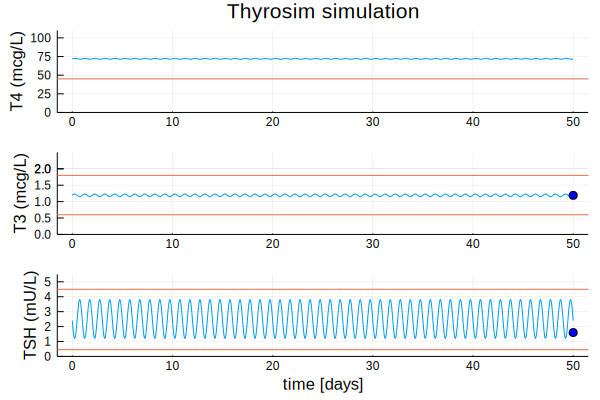

In [6]:
i = 2
T4secrete = secretion_rates[2i - 1]
T3secrete = secretion_rates[2i]
dial = [T4secrete; 0.88; T3secrete; 0.88] # T4 secretion, T4 absorbtion, T3 secret, T3 absorb
sol = simulate(height[i], weight_w1[i], sex[i], days=50, dial=dial, 
    fitting_index=fitting_index, parameters=train_minimizer)
plot_sim_data(sol, T4start[i], T3start[i], TSHstart[i])

# Check Fit with data

In [50]:
# define function for adding dose
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end
# simulate jonklaas patient over 16 weeks, interpolating weights weekly, returning T4/T3/TSH values
function simulate_one_jonklaas_patient_new(
    patient_idx::Int,
    result_minimzer::Vector, # first n elem is parameters, n+1:end is T4/T3 secrete rates
    fitting_index::Vector, 
    jonklaas_patient_param::Matrix, 
    jonklaas_patient_dose::Matrix,
    jonklaas_secrete_rate_clusters::Vector;
    verbose::Bool = true
    )
    # return vectors
    T4 = Float64[]
    T3 = Float64[]
    TSH = Float64[]
    times = Float64[]
    
    # other parameters
    dial = [1.0; 0.88; 1.0; 0.88]
    nsamples = size(jonklaas_patient_param, 1)
    cbk = PeriodicCallback(add_dose!, 24) 
    weight_w1 = jonklaas_patient_param[:, 1] # week 1 weight
    height = jonklaas_patient_param[:, 3]
    sex = convert(BitVector, jonklaas_patient_param[:, 4])
    secretion_rates = @view(result_minimzer[length(fitting_index)+1:end])
    
    # run model to steady state before actual simulation
    cluster = jonklaas_secrete_rate_clusters[patient_idx]
    dial[1] = secretion_rates[2cluster - 1]
    dial[3] = secretion_rates[2cluster]
    sol = simulate(height[patient_idx], weight_w1[patient_idx], sex[patient_idx], days=50, dial=dial, 
        warmup=false, fitting_index=fitting_index, parameters=result_minimzer[1:length(fitting_index)])
    _, p = initialize(dial, true, height[patient_idx], weight_w1[patient_idx], sex[patient_idx])
    p[fitting_index] .= @view(result_minimzer[1:length(fitting_index)])
    
    # run first 8 week simulations, interpolate weight weekly
    weight_diff = (jonklaas_patient_param[patient_idx, 2] - jonklaas_patient_param[patient_idx, 1]) / 16.0
    dial[1] = dial[3] = 0.0
    for week in 1:8
        # reset parameters using new weight
        ic, p = initialize(dial, true, height[patient_idx], weight_w1[patient_idx] + week*weight_diff, 
            sex[patient_idx])
        p[55] = jonklaas_patient_dose[patient_idx, 1] / 777.0
        p[fitting_index] .= @view(result_minimzer[1:length(fitting_index)])
        # use last week's end value
        ic .= sol[end]
        ic[10] += p[55] # manually add dose for first day of the week
        prob = ODEProblem(thyrosim,ic,(0.0, 168.0),p,callback=cbk)
        sol  = solve(prob)
        # record each week's value for plotting later 
        T4 = week == 1 ? 777.0 * sol[1, :] / p[47] : vcat(T4, 777.0 * sol[1, 2:end] / p[47])
        T3 = week == 1 ? 651.0 * sol[4, :] / p[47] : vcat(T3, 651.0 * sol[4, 2:end] / p[47])
        TSH = week == 1 ? 5.6 * sol[7, :] / p[48] : vcat(TSH, 5.6 * sol[7, 2:end] / p[48])
        times = week == 1 ? sol.t : vcat(times, sol.t[2:end] .+ times[end])
    end

    # run next 8 week, interpolate weight weekly
    verbose && println("week 1-8  dose = ", jonklaas_patient_dose[patient_idx, 1])
    verbose && println("week 9-16 dose = ", jonklaas_patient_dose[patient_idx, 2])
    for week in 9:16
        # reset parameters using new weight
        ic, p = initialize(dial, true, height[patient_idx], weight_w1[patient_idx] + week*weight_diff, sex[patient_idx])
        p[55] = jonklaas_patient_dose[patient_idx, 2] / 777.0
        p[fitting_index] .= @view(result_minimzer[1:length(fitting_index)])
        # use last week's end value
        ic .= sol[end]
        ic[10] += p[55] # manually add dose for first day of the week
        prob = ODEProblem(thyrosim,ic,(0.0, 168.0),p,callback=cbk)
        sol  = solve(prob)
        # record each week's value for plotting later 
        T4 = vcat(T4, 777.0 * sol[1, 2:end] / p[47])
        T3 = vcat(T3, 651.0 * sol[4, 2:end] / p[47])
        TSH = vcat(TSH, 5.6 * sol[7, 2:end] / p[48])
        times = vcat(times, sol.t[2:end] .+ times[end])
    end
    
    return T4, T3, TSH, times
end

FT4_to_TT4(FT4) = (0.000289 + 0.000214*FT4 + 0.000128*FT4 + -8.83*10^-6*FT4) * 100000FT4

function plot_jonklaas_new(
    patient_idx::Int,
    T4::Vector,    # simulated T4
    T3::Vector,    # simulated T3
    TSH::Vector,   # simulated TSH
    times::Vector, # time intervals (units = days)
    FT4data::Matrix,    # data
    T3data::Matrix,    # data
    TSHdata::Matrix;   # data
    title::AbstractString="Thyrosim simulation (Jonklaas new data)",
    automargins::Bool=true
    )

    markersize = 2
    #time in which data are measured
    t_data = [0.0, 56, 112] # 8 and 16 weeks
    T4data = FT4_to_TT4.(FT4data[patient_idx, :])
    
    # parameters to adjust figure limits
    t4lim, t3lim, tshlim = 140, 4, 10
    if automargins
        t4lim = max(1.2maximum(T4), 110.0, 1.2T4data...)
        t3lim = max(1.2maximum(T3), 2.5)
        tshlim = max(1.2maximum(TSH), 5.5)
    end

    p1 = plot(times, T4, ylim=(0, t4lim), label="",ylabel="T4 (mcg/L)", title=title)
    p1 = hline!([45, 105], label= "")
    p1 = scatter!(t_data, FT4_to_TT4.(FT4data[patient_idx, 2:4]), label="", markersize=markersize)

    p2 = plot(times, T3, ylim=(0, t3lim), label="", ylabel="T3 (mcg/L)")
    p2 = hline!([0.6, 1.8], label= "")
    p2 = scatter!(t_data, T3data[patient_idx, 2:4], label="", markersize=markersize)

    p3 = plot(times, TSH, ylim=(0, tshlim), label="", ylabel="TSH (mU/L)", xlabel="time [days]")
    p3 = hline!([0.45, 4.5], label= "")
    p3 = scatter!(t_data, TSHdata[patient_idx, 2:4], label="", markersize=markersize)

    plot(p1, p2, p3, layout=(3, 1))
end

plot_jonklaas_new (generic function with 1 method)

## Postfit (full simulation)

week 1-8  dose = 150.0
week 9-16 dose = 163.0


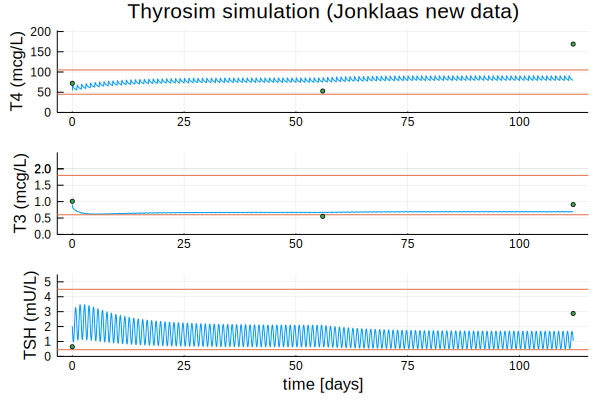

In [64]:
fitting_index = 
    [1; 21; 22; 
    30; 31; 
    49; 50; 51; 52; 53; 54;  # hill function parameters
    61; 62; 63;              # variance parameters
    66]

# fit slow compartment, female Vp, using updated schneider's data
train_minimizer = [0.002022669793525604, 0.0689682132927555, 127.00000004990338, 83.07868482871027, 52.80800520299285, 
    5.624894444841908, 4.443224571676052, 7.354901478321825, 7.587700872116656, 5.947246507576748, 
    9.560695294779237, 5.017195053412374, 0.9994762718239102, 1.0023262795671566, 2.5, 0.9998847513507683, 
    1.0000510586929023, 1.0002087392321246, 1.0000271583042606, 1.0005831848789721, 1.0000369363839154, 
    1.000277054775824, 0.99993890431708]
jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data_new()
jonklaas_secrete_rate_clusters = [4,2,2,1,3,1,3,1,2,1,2,4,1,2,1,3,1,2,3,1,3,4,4,1,1,3,4,1,1,1,2,1,1]

# make simulation
idx = 4
T4, T3, TSH, times = simulate_one_jonklaas_patient_new(idx, train_minimizer, fitting_index, 
    jonklaas_patient_param, jonklaas_patient_dose, jonklaas_secrete_rate_clusters)
plot_jonklaas_new(idx, T4, T3, TSH, times ./ 24, patient_t4, patient_t3, patient_tsh)

## Box plot to compare data vs simulation

In [54]:
function summarize_fit(train_minimizer, fitting_index)
    patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data_new()

    T4_data_p1, T4_sim_p1 = Float64[], Float64[]
    T4_data_p2, T4_sim_p2 = Float64[], Float64[]
    T4_data_p3, T4_sim_p3 = Float64[], Float64[]
    T3_data_p1, T3_sim_p1 = Float64[], Float64[]
    T3_data_p2, T3_sim_p2 = Float64[], Float64[]
    T3_data_p3, T3_sim_p3 = Float64[], Float64[]
    TSH_data_p1, TSH_sim_p1 = Float64[], Float64[]
    TSH_data_p2, TSH_sim_p2 = Float64[], Float64[]
    TSH_data_p3, TSH_sim_p3 = Float64[], Float64[]

    for i in 1:size(patient_param, 1)
        # run simulation
        T4, T3, TSH, times = simulate_one_jonklaas_patient_new(i, train_minimizer, fitting_index, 
            jonklaas_patient_param, jonklaas_patient_dose, jonklaas_secrete_rate_clusters, verbose=false)
        p1_time = 1
        p2_time = findfirst(x -> x == 24*7*8, times)
        p3_time = length(times)

        # predicted T4/T3/TSH
        push!(T4_sim_p1, T4[p1_time])
        push!(T4_sim_p2, T4[p2_time])
        push!(T4_sim_p3, T4[p3_time])
        push!(T3_sim_p1, T3[p1_time])
        push!(T3_sim_p2, T3[p2_time])
        push!(T3_sim_p3, T3[p3_time])
        push!(TSH_sim_p1, TSH[p1_time])
        push!(TSH_sim_p2, TSH[p2_time])
        push!(TSH_sim_p3, TSH[p3_time])

        # actual T4/T3/TSH
        T4data_p1, T4data_p2, T4data_p3 = FT4_to_TT4.(patient_t4[i, 2:4])
        T3data_p1, T3data_p2, T3data_p3 = patient_t3[i, 2:4]
        TSHdata_p1, TSHdata_p2, TSHdata_p3 = patient_tsh[i, 2:4]
        push!(T4_data_p1, T4data_p1)
        push!(T4_data_p2, T4data_p2)
        push!(T4_data_p3, T4data_p3)
        push!(T3_data_p1, T3data_p1)
        push!(T3_data_p2, T3data_p2)
        push!(T3_data_p3, T3data_p3)
        push!(TSH_data_p1, TSHdata_p1)
        push!(TSH_data_p2, TSHdata_p2)
        push!(TSH_data_p3, TSHdata_p3)
    end

    T4_t1_plt = boxplot(T4_sim_p1, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT4 (mcg/L)", 
        legend=false, title="T4 (time 1)")
    boxplot!(T4_t1_plt, T4_data_p1)

    T4_t2_plt = boxplot(T4_sim_p2, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT4 (mcg/L)", 
        legend=false, title="T4 (time 2)")
    boxplot!(T4_t2_plt, T4_data_p2)

    T4_t3_plt = boxplot(T4_sim_p3, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT4 (mcg/L)", 
        legend=false, title="T4 (time 3)")
    boxplot!(T4_t3_plt, T4_data_p3)

    T3_t1_plt = boxplot(T3_sim_p1, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT3 (mcg/L)", 
        legend=false, title="T3 (time 1)")
    boxplot!(T3_t1_plt, T3_data_p1)

    T3_t2_plt = boxplot(T3_sim_p2, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT3 (mcg/L)", 
        legend=false, title="T3 (time 2)")
    boxplot!(T3_t2_plt, T3_data_p2)

    T3_t3_plt = boxplot(T3_sim_p3, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT3 (mcg/L)", 
        legend=false, title="T3 (time 3)")
    boxplot!(T3_t3_plt, T3_data_p3)

    TSH_t1_plt = boxplot(TSH_sim_p1, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TSH (mU/L)", 
        legend=false, title="TSH (time 1)")
    boxplot!(TSH_t1_plt, TSH_data_p1)

    TSH_t2_plt = boxplot(TSH_sim_p2, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TSH (mU/L)", 
        legend=false, title="TSH (time 2)")
    boxplot!(TSH_t2_plt, TSH_data_p2)

    TSH_t3_plt = boxplot(TSH_sim_p3, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TSH (mU/L)", 
        legend=false, title="TSH (time 3)")
    boxplot!(TSH_t3_plt, TSH_data_p3)
    
    combined = plot(T4_t1_plt, T4_t2_plt, T4_t3_plt,
        T3_t1_plt, T3_t2_plt, T3_t3_plt,
        TSH_t1_plt, TSH_t2_plt, TSH_t3_plt,
        size=(800, 600), layout=(3, 3))
    return combined
end

summarize_fit (generic function with 2 methods)

## Prefit

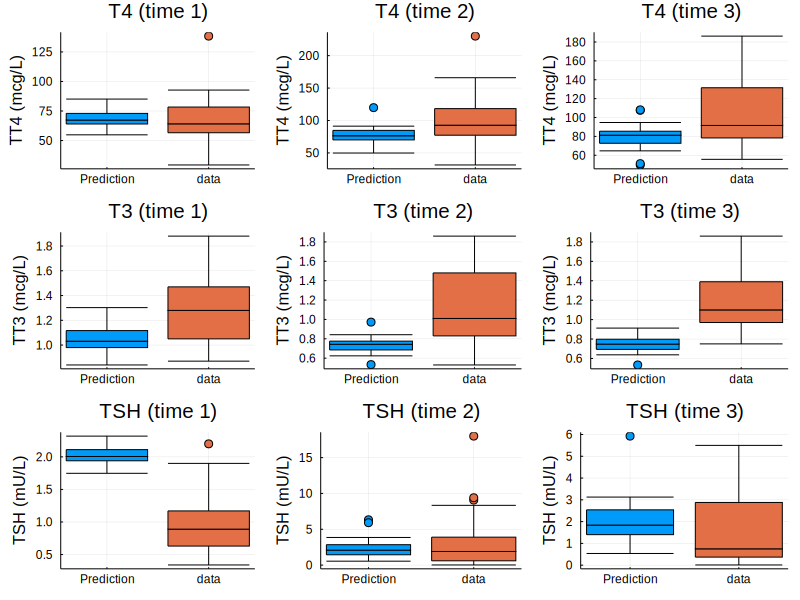

In [56]:
initial_guess = [ # best fit we have so far
    0.00238826; 0.0689; 127; 
    83.0787; 52.808; 
    5.62485; 4.4451; 7.355; 7.58711; 5.94623; 9.56078;
    5.0155; 1.0; 1.0;
    2.5]
initial_guess = [initial_guess; ones(8)]

fitting_index = 
    [1; 21; 22; 
    30; 31; 
    49; 50; 51; 52; 53; 54;  # hill function parameters
    61; 62; 63;              # variance parameters
    66]

# fit slow compartment, female Vp, using updated schneider's data
train_minimizer = [0.002022669793525604, 0.0689682132927555, 127.00000004990338, 83.07868482871027, 52.80800520299285, 
    5.624894444841908, 4.443224571676052, 7.354901478321825, 7.587700872116656, 5.947246507576748, 
    9.560695294779237, 5.017195053412374, 0.9994762718239102, 1.0023262795671566, 2.5, 0.9998847513507683, 
    1.0000510586929023, 1.0002087392321246, 1.0000271583042606, 1.0005831848789721, 1.0000369363839154, 
    1.000277054775824, 0.99993890431708]

plt = summarize_fit(initial_guess, fitting_index)

## Post fit

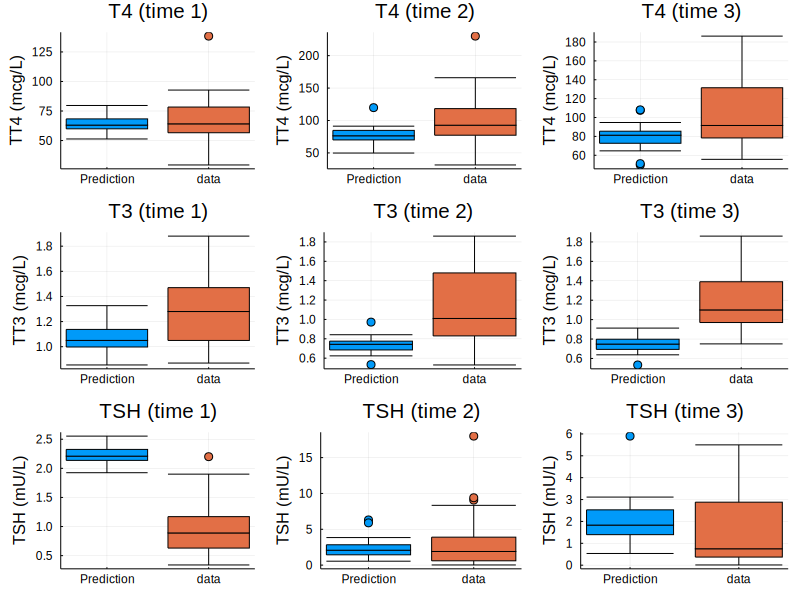

In [57]:
plt = summarize_fit(train_minimizer, fitting_index)